In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage.io import imread, imshow


##Import any other packages you may need here

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

DATAPATH = '/home/danielchan/Chest_Xray_Data/'

all_xray_df = pd.read_csv(DATAPATH+'Data_Entry_2017.csv')
all_xray_df.sample(3)

#data_sample = pd.read_csv('sample_labels.csv')
#data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
77399,00019018_001.png,Infiltration,1,19018,28,M,AP,3056,2544,0.139,0.139,NaN
546,00000131_002.png,Cardiomegaly|Emphysema,2,131,55,M,PA,2500,2048,0.168,0.168,NaN
16911,00004533_015.png,No Finding,15,4533,30,M,PA,2992,2991,0.143,0.143,NaN


**find the number of unique patients**

In [3]:
print ( "Number of Unique Patients: ", len(np.unique( all_xray_df['Patient ID'].values ) ) )

Number of Unique Patients:  30805


In [4]:
#data_sample['Patient Age'] = data_sample['Patient Age'].map(lambda x: str(x)[:-1]).astype(int)

**Let's look the demographic dsitribution for age and gender**

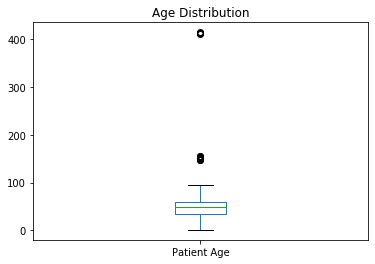

In [5]:
all_xray_df['Patient Age'].plot(kind='box',title='Age Distribution')

**There are some outliners in the data (highly unlikely to have a 414 years old person), we will narrow the age group to 1 standard deviation from the mean**

In [6]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

In [7]:
factor = 1.0
pMean = all_xray_df['Patient Age'].mean()
pstd  = all_xray_df['Patient Age'].std()
pAgeLower = int(pMean - factor*pstd)
pAgeUpper = int(pMean + factor*pstd)

print ("Lower and Upper Bound for Age:",pAgeLower, pAgeUpper)

Lower and Upper Bound for Age: 30 63


In [8]:
filtered = all_xray_df[ (all_xray_df['Patient Age'] >= pAgeLower) &  
                        (all_xray_df['Patient Age'] <= pAgeUpper)  ]

In [9]:
print ( filtered.shape[0]/all_xray_df.shape[0]*100, "% of the data set" )

66.34944702104887 % of the data set


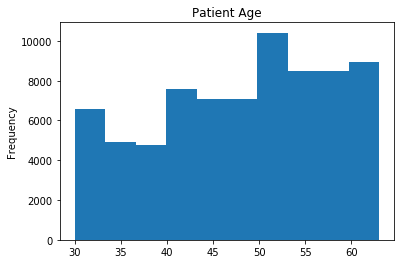

In [10]:
filtered['Patient Age'].plot(kind='hist',title='Patient Age')

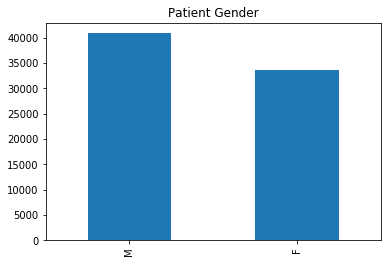

In [11]:
filtered['Patient Gender'].value_counts().plot(kind='bar',title='Patient Gender')

In [12]:
filtered['Patient Gender'].value_counts()

M    40879
F    33512
Name: Patient Gender, dtype: int64

In [13]:
# remove the original dataframe to preserve memory
del all_xray_df

**Both age and gender distributions look good, i.e. it is balanced**

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

### Extract training data set for Pneumonia

In [14]:
all_labels = np.unique(list(chain(*filtered['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        filtered[c_label] = filtered['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
filtered.sample(5)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
101347,00026925_005.png,No Finding,5,26925,38,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7996,00002094_005.png,No Finding,5,2094,54,M,PA,2758,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70040,00017242_000.png,Atelectasis|Infiltration,0,17242,40,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98542,00026050_000.png,Atelectasis|Effusion|Mass,0,26050,51,M,PA,2790,2836,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
64269,00015852_007.png,Nodule,7,15852,44,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
len(all_labels)

15

**Let's find out more about No Finding, Number of Pneumonia Cases, Unique Patient IDs and View Positions**

In [16]:
filtered['No Finding'].value_counts()

1.0    40376
0.0    34015
Name: No Finding, dtype: int64

In [17]:
filtered['Pneumonia'].value_counts()

0.0    73499
1.0      892
Name: Pneumonia, dtype: int64

In [18]:
filtered[ filtered['Pneumonia']==1]['View Position'].value_counts()

AP    489
PA    403
Name: View Position, dtype: int64

In [19]:
# number of unique patients with Pneumonia
len (np.unique( filtered[ filtered['Pneumonia']==1]['Patient ID'].values ))

644

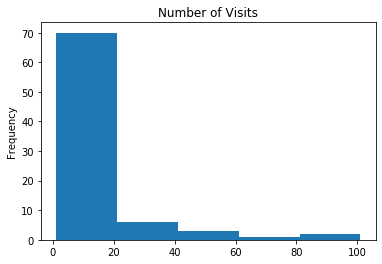

In [20]:
# look at how many repeat visits are there
filtered[ filtered['Pneumonia']==1]['Follow-up #'].value_counts().plot(kind='hist',bins=5,title="Number of Visits")

In [21]:
filtered[ filtered['Pneumonia']==1]['Follow-up #'].value_counts().describe()

count     82.000000
mean      10.878049
std       18.867563
min        1.000000
25%        1.000000
50%        3.000000
75%        9.750000
max      101.000000
Name: Follow-up #, dtype: float64

**75% of positive Pneumonia cases have less than 10 visits**

### Let's look at the age distribution for different diseases

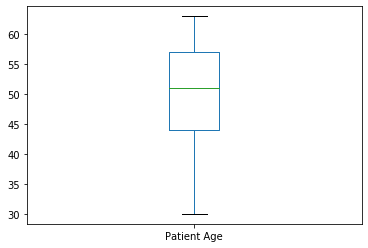

In [22]:
# for Atelectasis

filtered[filtered['Atelectasis']==1]['Patient Age'].plot(kind='box')

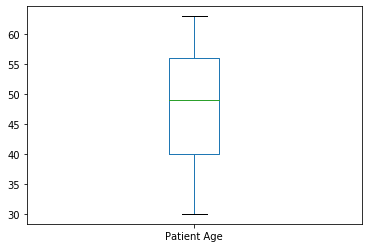

In [23]:
# for Edema

filtered[filtered['Edema']==1]['Patient Age'].plot(kind='box')

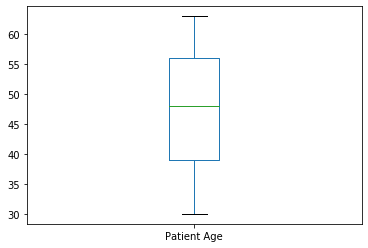

In [24]:
# for Pneumonia

filtered[filtered['Pneumonia']==1]['Patient Age'].plot(kind='box')

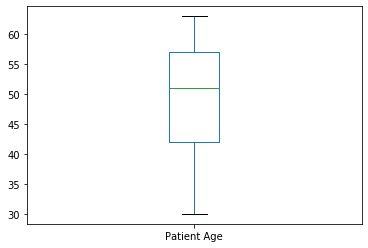

In [25]:
# for Effusion

filtered[filtered['Effusion']==1]['Patient Age'].plot(kind='box')

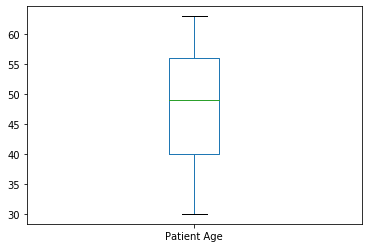

In [26]:
# for Infiltration

filtered[filtered['Infiltration']==1]['Patient Age'].plot(kind='box')

In [27]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['Follow-up #'].value_counts().describe()

count    76.000000
mean      8.131579
std      12.179044
min       1.000000
25%       1.000000
50%       2.500000
75%       8.000000
max      54.000000
Name: Follow-up #, dtype: float64

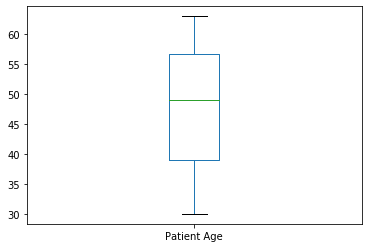

In [28]:
# Age distribution for those who have Pneumonia and one other disease

filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['Patient Age'].plot(kind='box')

In [29]:
filtered[   (filtered['Infiltration']==1)   |
            (filtered['Effusion']==1)       |
            (filtered['Edema']==1 )         |
            (filtered['Atelectasis']==1)       ]['Pneumonia'].value_counts()

0.0    23361
1.0      618
Name: Pneumonia, dtype: int64

# Describe how to set up the model training based on the findings

In [30]:
## frequency of co-occurence with other diseases

for d in all_labels:
    print ( d," ",filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]/892. )

Atelectasis   0.20291479820627803
Cardiomegaly   0.030269058295964126
Consolidation   0.09865470852017937
Edema   0.242152466367713
Effusion   0.1961883408071749
Emphysema   0.013452914798206279
Fibrosis   0.010089686098654708
Hernia   0.0033632286995515697
Infiltration   0.4024663677130045
Mass   0.05493273542600897
No Finding   0.0
Nodule   0.05493273542600897
Pleural_Thickening   0.034753363228699555
Pneumonia   1.0
Pneumothorax   0.034753363228699555


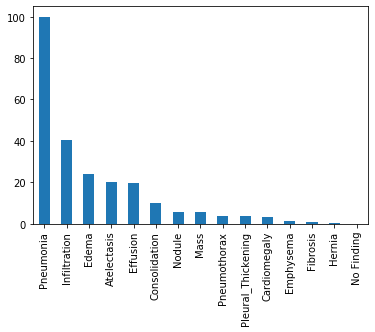

In [31]:
occur ={}
for d in all_labels:
    occur[d] = filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]/892.*100. 
series = pd.Series(occur).sort_values(ascending=False)
series.plot(kind='bar')

**Top 4 most common comorbidities are: Infiltration, Edema, Atelectasis​ and Effusion**

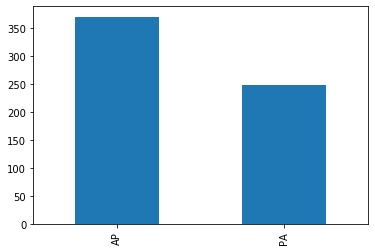

In [32]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts().plot(kind='bar')

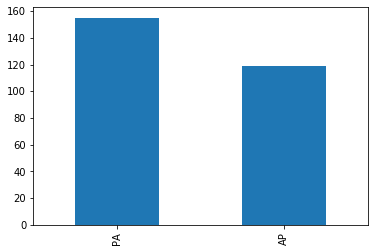

In [33]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==0) &
            (filtered['Effusion']==0)     &
            (filtered['Edema']==0 )       &
            (filtered['Atelectasis']==0) )]['View Position'].value_counts().plot(kind='bar')

**It looks like PA view produces more positive Pneumonia cases**

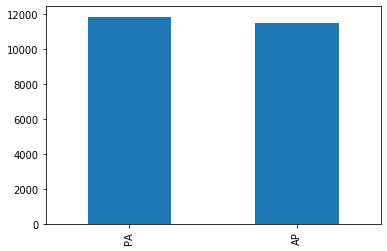

In [34]:
filtered[ (filtered['Pneumonia']==0)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts().plot(kind='bar')

In [35]:
filtered.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,00000013_000.png,No Finding,0,13,61,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39,00000013_001.png,Emphysema|Pneumothorax,1,13,60,M,AP,3056,2544,0.139000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(DATAPATH,'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', filtered.shape[0])
filtered['path'] = filtered['Image Index'].map(all_image_paths.get)
filtered.sample(3)



Scans found: 112120 , Total Headers 74391


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
98025,00025851_005.png,Cardiomegaly|Infiltration|Pneumonia,5,25851,37,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/danielchan/Chest_Xray_Data/images_011/im...
23771,00006271_102.png,Infiltration,102,6271,40,M,AP,2500,2048,0.171,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/home/danielchan/Chest_Xray_Data/images_003/im...
15141,00003981_000.png,No Finding,0,3981,60,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/home/danielchan/Chest_Xray_Data/images_003/im...


## Look at pixel intensitites for different diseases

In [37]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

# for Pneumonia

samp = filtered[(filtered['Pneumonia']==1 ) &
                (filtered['View Position']=="AP")  
               ].sample(5)['path'].values

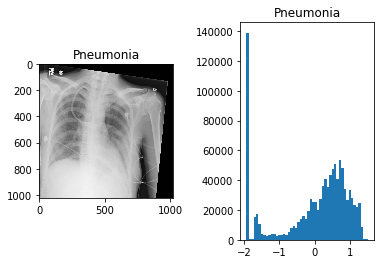

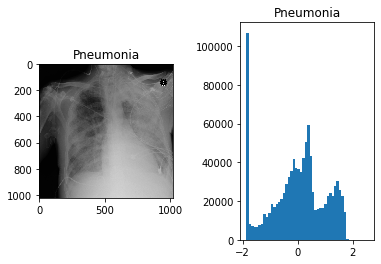

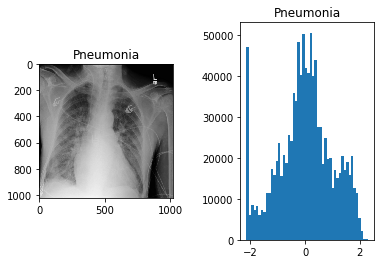

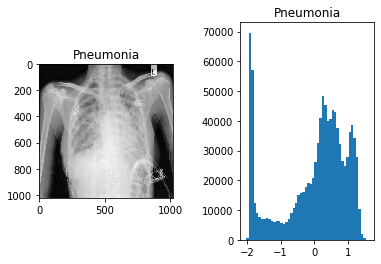

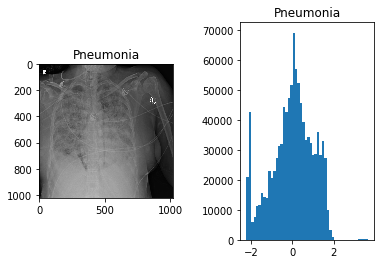

In [56]:
for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.title('Pneumonia')

    plt.subplot(1, 2, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.title('Pneumonia')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

#plt.figure(figsize=(5,5))
#plt.hist(dcm.pixel_array.ravel(), bins = 256)

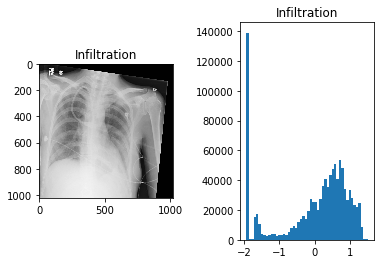

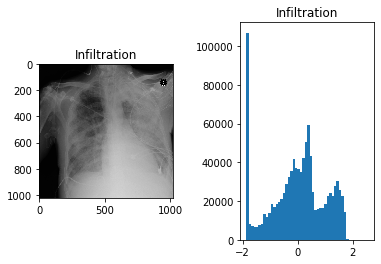

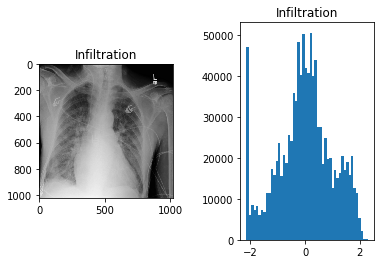

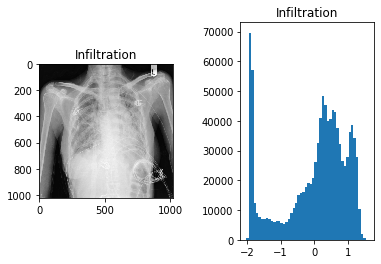

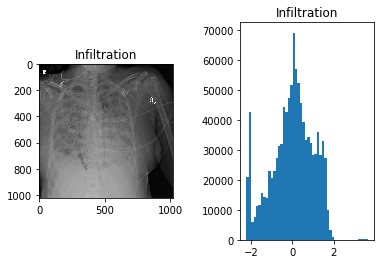

In [55]:
# for Infiltration

samp = filtered[(filtered['Infiltration']==1 ) &
                (filtered['View Position']=="AP")  
               
               ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.title('Infiltration')

    plt.subplot(1, 2, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.title('Infiltration')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

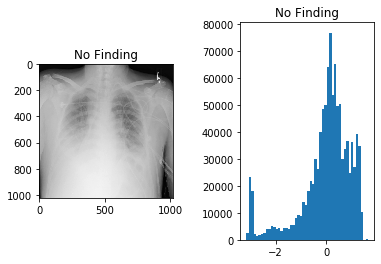

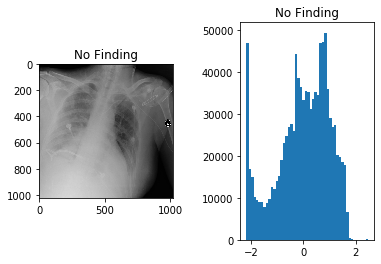

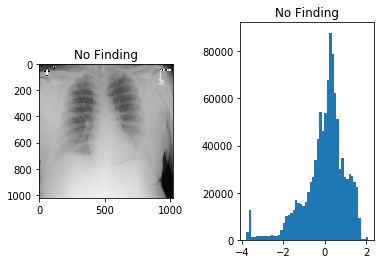

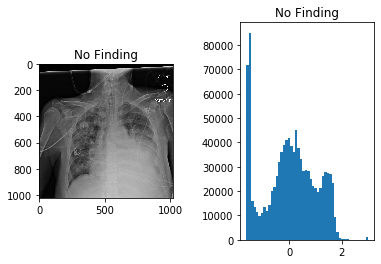

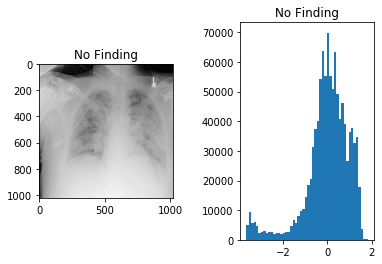

In [54]:
samp = filtered[ (filtered['No Finding']==0)  &
                 (filtered['View Position']=="AP")].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.title('No Finding')

    plt.subplot(1, 2, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.title('No Finding')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

**It looks like Pneumonia cases have a higher concentration at pixel intensity value of 100**

In [41]:
# look at the possibility of removing the impact of other diseases

filteredPN = filtered[ (filtered['Pneumonia']==1)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']=="AP") ].sample(5)['path'].values
filteredNo = filtered[ (filtered['No Finding']==1)   &  
                       (filtered['View Position']=="AP") ].sample(5)['path'].values



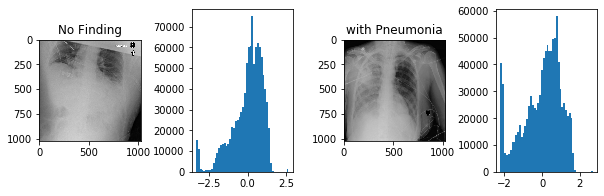

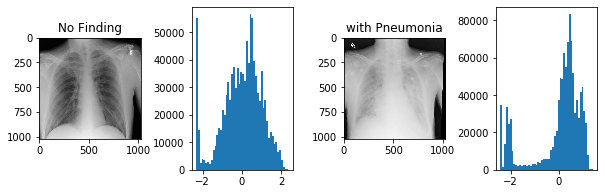

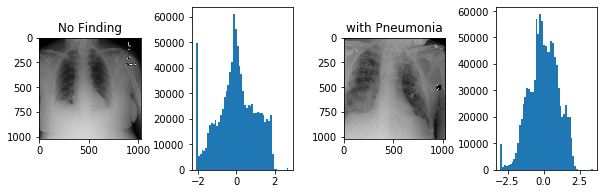

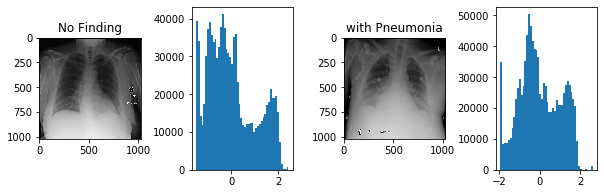

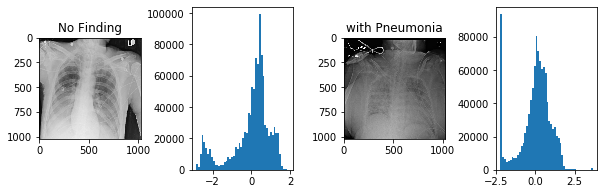

In [52]:

for img1, img2 in zip(filteredNo,filteredPN):
    plt.figure(figsize=(10.,3.))
    plt.subplot(1, 4, 1)
    pic = imread( img1 )
    plt.imshow(pic,cmap='gray')
    plt.title('No Finding')
    plt.subplot(1, 4, 2)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)
    plt.ylim=(0, 0.1)
    plt.subplot(1, 4, 3)
    pic = imread( img2 )
    plt.imshow(pic,cmap='gray')
    plt.title('with Pneumonia')

    plt.subplot(1, 4, 4)
    pic = pic.ravel()
    pic = (pic - pic.mean())/pic.std()
    plt.hist(pic, bins=50,density=False)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

In [43]:
filteredD ={}
filteredD['Pneumonia'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==1)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']=="AP") ].sample(5)['path'].values

In [44]:
filteredD

{'Pneumonia': array(['/home/danielchan/Chest_Xray_Data/images_003/images/00006271_094.png',
        '/home/danielchan/Chest_Xray_Data/images_003/images/00003990_010.png',
        '/home/danielchan/Chest_Xray_Data/images_006/images/00012834_107.png',
        '/home/danielchan/Chest_Xray_Data/images_003/images/00006519_011.png',
        '/home/danielchan/Chest_Xray_Data/images_011/images/00026261_007.png'],
       dtype=object)}

In [49]:
VIEW = "AP"
#VIEW = "PA"


filteredD['Pneumonia'] = filtered[ (filtered['Pneumonia']==1)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW)       &
            (filtered['Follow-up #'] >2 )       ].sample(5)['path'].values


filteredD['Infiltration'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==1)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['Effusion'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==1)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['Edema'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==1 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['Atelectasis'] = filtered[ (filtered['Pneumonia']==0)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==1) )          &
            (filtered['View Position']==VIEW) ].sample(5)['path'].values

filteredD['No Finding'] = filtered[ (filtered['No Finding']==1)   &  
                       (filtered['View Position']==VIEW) ].sample(5)['path'].values



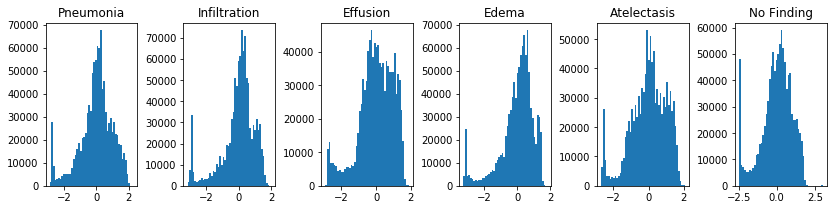

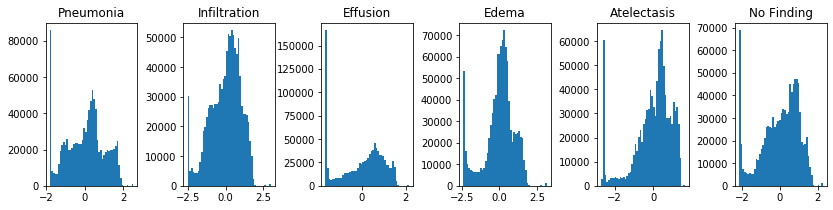

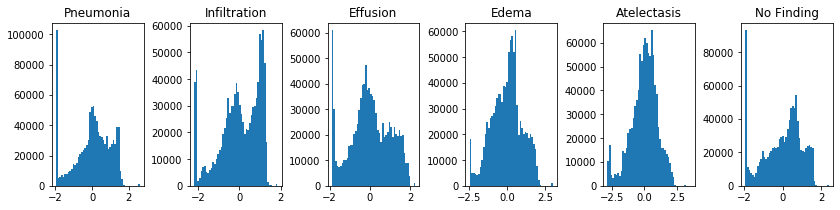

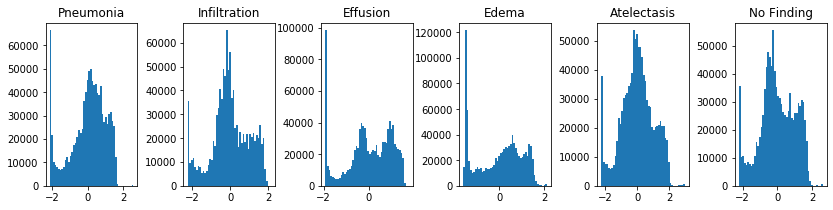

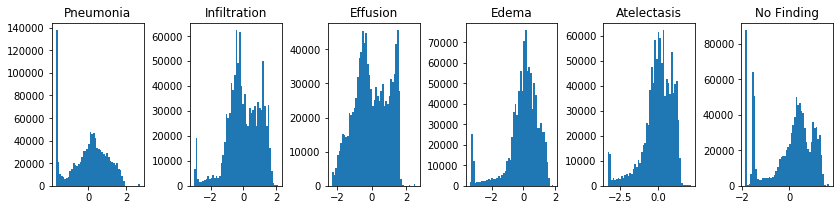

In [50]:
diseases = ['Pneumonia','Infiltration','Effusion','Edema','Atelectasis','No Finding']
for sample in range(5):
    plt.figure(figsize=(14.,3.))
    ip = 0
    for disease in diseases:
        plt.subplot(1, 6, ip+1)
        pic = imread( filteredD[disease][sample] )
        plt.title(disease)
        pic = pic.ravel()
        pic = (pic - pic.mean())/pic.std()
        plt.hist(pic, bins = 50,density=False)
        ip = ip +1
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.show()